In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import transformers
from transformers import LayoutLMv2Processor, LayoutLMForTokenClassification, AdamW, BertForTokenClassification,\
    BertTokenizer, LayoutLMTokenizer, AutoTokenizer
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix
from copy import deepcopy

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.make_dataset import ImageLayoutDataset
from src.model.trainer import BertTrainer, LayoutLMTrainer
import warnings
warnings.filterwarnings("ignore")

In [4]:
!mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [5]:
model_name = "few_shot_learning"
dataset_name = "cord"

In [6]:
logging.basicConfig(filename='logs/few_shot_learning_cord.log', encoding='utf-8', level= logging.INFO)

## Obtaining data

In [7]:
dataset = load_dataset("katanaml/cord")

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 800
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 100
    })
})

In [9]:
dataset['train'].features['ner_tags'].feature.names

['O',
 'I-menu.cnt',
 'I-menu.discountprice',
 'I-menu.nm',
 'I-menu.num',
 'I-menu.price',
 'I-menu.sub_cnt',
 'I-menu.sub_nm',
 'I-menu.sub_price',
 'I-menu.unitprice',
 'I-sub_total.discount_price',
 'I-sub_total.etc',
 'I-sub_total.service_price',
 'I-sub_total.subtotal_price',
 'I-sub_total.tax_price',
 'I-total.cashprice',
 'I-total.changeprice',
 'I-total.creditcardprice',
 'I-total.emoneyprice',
 'I-total.menuqty_cnt',
 'I-total.menutype_cnt',
 'I-total.total_etc',
 'I-total.total_price']

In [10]:
n_classes = len(dataset['train'].features['ner_tags'].feature.names)
n_classes

23

In [11]:
bert_tokenizer =AutoTokenizer.from_pretrained("bert-base-uncased")

In [12]:
llm_tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutlm-base-uncased",)

## BERT

In [13]:
train_dataset = ImageLayoutDataset(
    dataset['train'], 
    tokenizer=bert_tokenizer,
    tokenize_all_labels=True
)

100%|██████████| 800/800 [00:02<00:00, 288.16it/s]


In [14]:
validation_dataset = ImageLayoutDataset(
    dataset['validation'],
    tokenizer= bert_tokenizer,
    tokenize_all_labels=True
)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 279.66it/s]


In [18]:
test_dataset = ImageLayoutDataset(
    dataset['test'],
    tokenizer= bert_tokenizer,
    tokenize_all_labels=True
)

100%|██████████| 100/100 [00:00<00:00, 263.19it/s]


In [15]:
device = "cuda"

In [25]:
n = len(train_dataset)
history= {}
test = {}

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle = False
)

for num_samples in [2,5,10,100]:

    train_dataloader = DataLoader(
        train_dataset[0: num_samples],
        batch_size=2,
        shuffle = False
    )

    bert = BertForTokenClassification\
        .from_pretrained(
            'bert-base-uncased', 
            num_labels = n_classes
        )
    
    bert.to(device)

    trainer = BertTrainer(
        bert
    )

    print(f"training {trainer.model_name} with {num_samples} samples")

    trainer.compile(
        train_dataloader,
        validation_dataloader,
        n_classes= n_classes,
        device = "cuda"
    )
    test_dataloader = DataLoader(
        test_dataset,
        batch_size = 1
    )
    f1, conf_matrix = trainer.evaluate(
        test_dataloader,
        n_classes= n_classes
    )

    history[num_samples] = trainer.history

    test[num_samples]={

        'f1': f1,
        'confusion_matrix': conf_matrix
    }

f1: 0.8690476417541504


In [30]:
test[5]

{'f1': tensor(0.6057, device='cuda:0'),
 'confusion_matrix': tensor([[   0,    2,    0,   10,    0,   14,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    3],
         [   0,  243,    0,    3,    0,   10,    0,    0,    0,    0,    0,    0,
             0,    2,    0,    0,    2,    0,    0,    0,    0,    0,    1],
         [   0,    9,    0,   11,    0,   32,    0,    0,    0,    0,    0,    0,
             1,    9,   14,    0,    4,    0,    0,    0,    0,    0,    8],
         [   0,   49,    0, 1067,    0,   42,    6,    0,    0,    0,    0,    0,
             1,   24,    3,    2,    5,    0,    0,    0,    0,    0,    4],
         [   0,    4,    0,   12,    0,   10,    0,    0,    0,    1,    0,    0,
             0,   14,   10,    0,    0,    0,    0,    0,    0,    0,    2],
         [   0,   10,    0,    5,    0,  718,    0,    0,    0,    1,    0,    0,
             0,   19,   11,    4,    9,    0,    0,    0,    0,

In [36]:
for k,v in test.items():
    print(f'{k} samples: {v["f1"].item()}')

2 samples: 0.4319455623626709
5 samples: 0.6056845188140869
10 samples: 0.7155724763870239
100 samples: 0.8867093920707703


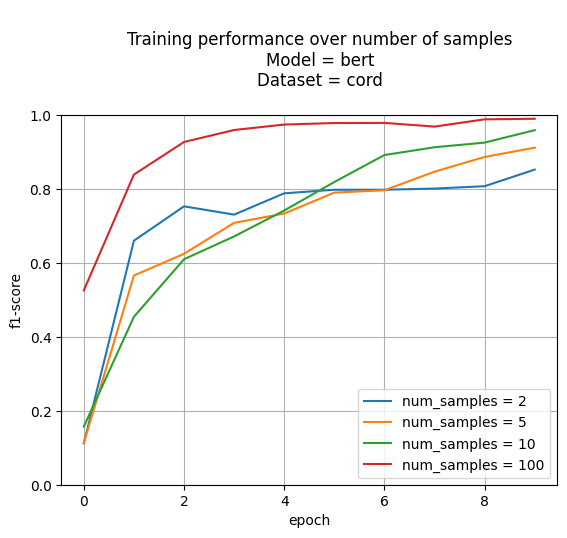

In [31]:
for k in history.keys():
    data = history[k]['train-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}"
    )

plt.title(f'''
    Training performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

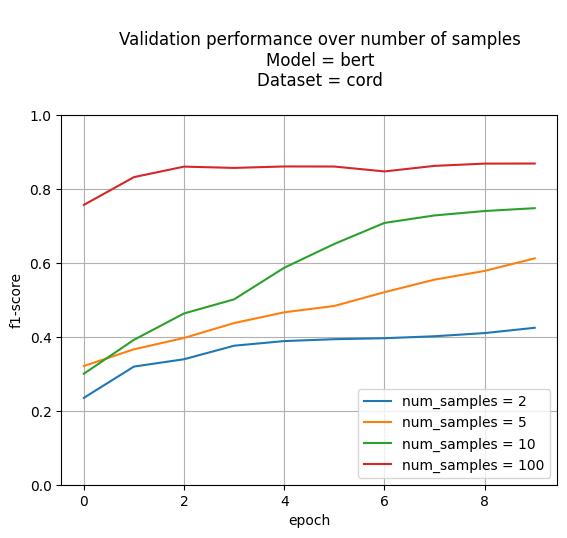

In [32]:
for k in history.keys():
    data = history[k]['validation-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}"
    )

plt.title(f'''
    Validation performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

## LayoutLM

In [14]:
train_dataset = ImageLayoutDataset(
    dataset['train'], 
    tokenizer=llm_tokenizer,
    tokenize_all_labels=True
)

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [00:08<00:00, 91.43it/s] 


In [15]:
validation_dataset = ImageLayoutDataset(
    dataset['validation'],
    tokenizer= llm_tokenizer,
    tokenize_all_labels=True
)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 91.86it/s]


In [17]:
test_dataset = ImageLayoutDataset(
    dataset['test'],
    tokenizer= bert_tokenizer,
    tokenize_all_labels=True
)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 91.92it/s]


In [ ]:
device = "cuda"

In [20]:
n = len(train_dataset)
history= {}
test = {}

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle = False
)

for num_samples in [2,5,10,100]:

    train_dataloader = DataLoader(
        train_dataset[0: num_samples],
        batch_size=2,
        shuffle = False
    )

    layoutlm = LayoutLMForTokenClassification\
        .from_pretrained(
            'microsoft/layoutlm-base-uncased', 
            cache_dir = '/Data/pedro.silva/',
            num_labels = n_classes
        )
    
    layoutlm.to(device)

    trainer = LayoutLMTrainer(
        layoutlm
    )

    print(f"training {trainer.model_name} with {num_samples} samples")

    trainer.compile(
        train_dataloader,
        validation_dataloader,
        n_classes= n_classes,
        device = "cuda"
    )
    test_dataloader = DataLoader(
        test_dataset,
        batch_size = 1
    )
    f1, conf_matrix = trainer.evaluate(
        test_dataloader,
        n_classes= n_classes
    )

    history[num_samples] = trainer.history

    test[num_samples]={

        'f1': f1,
        'confusion_matrix': conf_matrix
    }

f1: 0.7921075820922852


In [21]:
for k,v in test.items():
    print(f'{k} samples: {v["f1"].item()}')

2 samples: 0.39931946992874146
5 samples: 0.4445556402206421
10 samples: 0.46056845784187317
100 samples: 0.7506004571914673


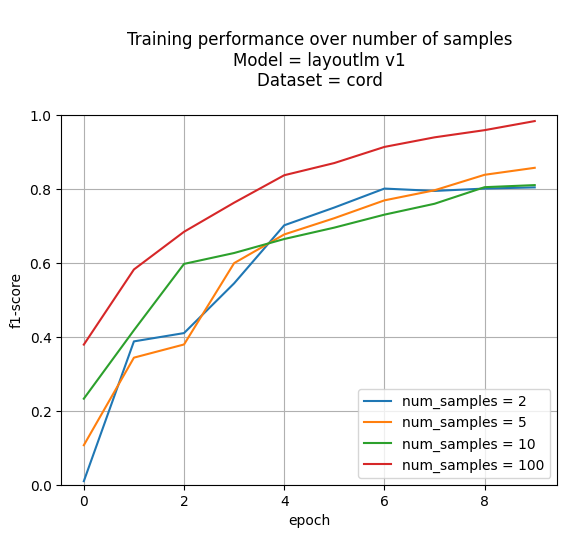

In [22]:
for k in history.keys():
    data = history[k]['train-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}"
    )

plt.title(f'''
    Training performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

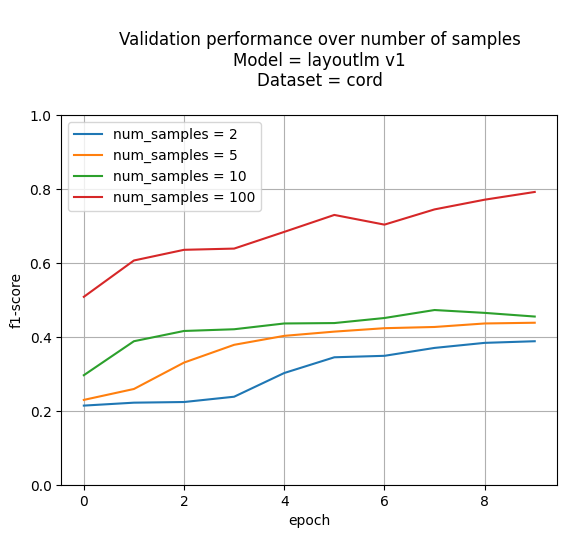

In [23]:
for k in history.keys():
    data = history[k]['validation-f1']
    plt.plot(
        data,
        label = f"num_samples = {k}"
    )

plt.title(f'''
    Validation performance over number of samples
    Model = {trainer.model_name}
    Dataset = {dataset_name}
''')

plt.xlabel("epoch")
plt.ylabel("f1-score")
plt.ylim([0,1])
plt.grid()
plt.legend()
plt.show()

## Finetuning Results

In [18]:
train_dataset = ImageLayoutDataset(
    dataset['train'], 
    tokenizer=llm_tokenizer
)
validation_dataset = ImageLayoutDataset(
    dataset['test'],
    tokenizer= llm_tokenizer
)
device = "cuda"
n = len(train_dataset)
history_layoutlm= {}

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle = False
)

experiments = [2,5,10]

for num_samples in experiments:
    train_dataloader = DataLoader(
        train_dataset[0: num_samples],
        batch_size=2,
        shuffle = False
    )

    layoutlm = LayoutLMForTokenClassification\
        .from_pretrained(
            'microsoft/layoutlm-base-uncased', 
            num_labels = n_classes
        )
    
    layoutlm.to(device)

    trainer = LayoutLMTrainer(
        layoutlm
    )

    print(f"training {trainer.model_name} with {num_samples} samples")

    trainer.compile(
        train_dataloader,
        validation_dataloader,
        n_classes= n_classes,
        device = "cuda"
    )

    history_layoutlm[num_samples] = trainer.history

  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 1056.60it/s]
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training layoutlm v1 with 2 samples


100%|██████████| 1/1 [00:00<00:00, 10.51it/s]
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training layoutlm v1 with 5 samples


100%|██████████| 3/3 [00:00<00:00, 13.77it/s]
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training layoutlm v1 with 10 samples


100%|██████████| 5/5 [00:00<00:00,  9.33it/s]


In [19]:
for k in history_layoutlm.keys():
    print(f"{k} shots -- f1 :  {np.max(history_layoutlm[k]['validation-f1'])}")

2 shots -- f1 :  0.4529262185096741
5 shots -- f1 :  0.5593723654747009
10 shots -- f1 :  0.711620032787323
